## Imports

In [60]:
import tweepy
import wordcloud
import datetime
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import time
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import numpy as np
import nltk.sentiment.vader as vd
from nltk import download
from nltk.probability import FreqDist
import seaborn as sns


In [61]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Twitter Authentication

In [62]:

consumerKey = "KyLeElLxqrKT6IcpL626Q3Cwh"
consumerSecret = "EoynxqoBOaWYdLzUzN12nhYVadQXVQ8KozIvDWTSxqYQd21PCc"

auth = tweepy.AppAuthHandler(consumerKey, consumerSecret)

# Create a wrapper for the Twitter API
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)



##Collecting data from Twitter

In [63]:
def limit_handled(cursor):
    while True:
        try:
            yield cursor.next()
        except tweepy.RateLimitError:
            print('Reached rate limite. Sleeping for >15 minutes')
            time.sleep(15 * 61)
        except StopIteration:
            break

# Define the query/hashtag
query = '#ElezioniPolitiche2022 -filter:retweets'

# Define the number of tweets
count = 12000

#Define the last date for considering tweets

endDate = datetime.datetime(2022, 9, 1, 0, 0, 0)


# Search for tweets using Tweepy
search = limit_handled(tweepy.Cursor(api.search,
                       q=query,
                       tweet_mode='extended',
                       lang='it').items(count))


tweets = [{'Tweets':tweet.full_text, 'Date':tweet.created_at} for tweet in search for tweet in search if tweet.created_at < endDate]

  
#Store as Dataframe
import pandas as pd   #%recallll the import because sometimes the session expires (long running time)

df = pd.DataFrame.from_dict(tweets)

#removing time from date
df['Date'] = pd.to_datetime(df['Date']).dt.date



df

,Tweets,Date
0,Conferenza stampa di presentazione delle liste...,2022-08-31
1,La serietà con la quale il leader del #TerzoPo...,2022-08-31
2,#calenda e #renzi già alleati con l' estrema #...,2022-08-31
3,Che è come dire “Basta con il bipopulismo port...,2022-08-31
4,È bello vedere con i propri occhi tantissimi r...,2022-08-31
...,...,...
10910,"Che buffonate sta combinando sto PD, su Calend...",2022-08-23
10911,Vogliono pagare col pos e gli sfascia i bagagl...,2022-08-23
10912,@EnricoLetta Leggi bene! Infame #ElezioniPolit...,2022-08-23
10913,"Ora che c’è l’ufficialità,sarà un sincero piac...",2022-08-23


In [64]:
#Keywords for identify the parties
pd = ['pd', 'partito democratico', 'letta', 'enrico letta', '#pd', '#PD', 'PD', 'Partito Democratico', 'Letta', 'Enrico Letta', '#Letta', 'EnricoLetta']
fdi = ['fdi', "fratelli d'italia", 'fratelli di italia', 'meloni',  'giorgia meloni', 'Meloni', 'Giorgia Meloni', 'FDI', 'Fratelli Di Italia', "Fratelli D'Italia", '#FDI', '#Meloni', 'GiorgiaMeloni', '#fdi']


def identify_subject(tweet, refs):
    flag = 0 
    for ref in refs:
        if tweet.find(ref) != -1:
            flag = 1
    return flag

df['PD'] = df['Tweets'].apply(lambda x: identify_subject(x, pd)) 
df['FDI'] = df['Tweets'].apply(lambda x: identify_subject(x, fdi))

df.head(10)

,Tweets,Date,PD,FDI
0,Conferenza stampa di presentazione delle liste...,2022-08-31,0,0
1,La serietà con la quale il leader del #TerzoPo...,2022-08-31,0,0
2,#calenda e #renzi già alleati con l' estrema #...,2022-08-31,0,0
3,Che è come dire “Basta con il bipopulismo port...,2022-08-31,0,0
4,È bello vedere con i propri occhi tantissimi r...,2022-08-31,0,0
5,@TgLa7 @luigidimaio Alla fine ti sei candidato...,2022-08-31,1,0
6,@RM_marco01 il 72 lo ricorderei piuttosto per ...,2022-08-31,0,0
7,@pietroraffa E vedrai dove arriva alle #Elezio...,2022-08-31,0,0
8,Vabbè fate finta ma non volete vincere #Elezio...,2022-08-31,1,0
9,@GiorgiaMeloni Cominci a essere chiara lei. No...,2022-08-31,0,1


## Data Cleaning  

In [65]:
#Lowercase all tweets
df['Clean_Tweets'] = df['Tweets'].astype(str).str.lower()

#Function to clean the tweets
def cleanTxt(text):
  text = re.sub(r'@[a-z0-9]+', '', text) #removing @
  text = re.sub(r'#[a-z0-9]+', '', text) #removing hashtags
  text = re.sub(r'rt[\s]+', '', text) #removing RT
  text = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', ' ', text ) #removing the hyperlinks
  text  = "".join([char for char in text if char not in string.punctuation]) #removing punctuation
  text = re.sub(r'\n', ' ', text)   #remove new lines
  return text 

df['Clean_Tweets'] = df['Clean_Tweets'].apply(cleanTxt)

#Show cleaned text

print(df.shape)

df

(10915, 5)


,Tweets,Date,PD,FDI,Clean_Tweets
0,Conferenza stampa di presentazione delle liste...,2022-08-31,0,0,conferenza stampa di presentazione delle liste...
1,La serietà con la quale il leader del #TerzoPo...,2022-08-31,0,0,la serietà con la quale il leader del accusa ...
2,#calenda e #renzi già alleati con l' estrema #...,2022-08-31,0,0,e già alleati con l estrema pro e fan di ...
3,Che è come dire “Basta con il bipopulismo port...,2022-08-31,0,0,che è come dire “basta con il bipopulismo port...
4,È bello vedere con i propri occhi tantissimi r...,2022-08-31,0,0,è bello vedere con i propri occhi tantissimi r...
...,...,...,...,...,...
10910,"Che buffonate sta combinando sto PD, su Calend...",2022-08-23,1,0,che buffonate sta combinando sto pd su calenda...
10911,Vogliono pagare col pos e gli sfascia i bagagl...,2022-08-23,0,1,vogliono pagare col pos e gli sfascia i bagagl...
10912,@EnricoLetta Leggi bene! Infame #ElezioniPolit...,2022-08-23,1,0,leggi bene infame
10913,"Ora che c’è l’ufficialità,sarà un sincero piac...",2022-08-23,0,0,ora che c’è l’ufficialitàsarà un sincero piace...


In [66]:

#removing the duplicates
df.drop_duplicates(subset='Clean_Tweets',inplace=True)
df.shape


(10070, 5)

## Preprocessing

In [67]:
#tokenize the tweets

regexp = RegexpTokenizer('\w+')

# Create a new column for te tokenized tweets
df['Tweets_token']=df['Clean_Tweets'].astype(str).apply(regexp.tokenize)
df.head(10)

,Tweets,Date,PD,FDI,Clean_Tweets,Tweets_token
0,Conferenza stampa di presentazione delle liste...,2022-08-31,0,0,conferenza stampa di presentazione delle liste...,"[conferenza, stampa, di, presentazione, delle,..."
1,La serietà con la quale il leader del #TerzoPo...,2022-08-31,0,0,la serietà con la quale il leader del accusa ...,"[la, serietà, con, la, quale, il, leader, del,..."
2,#calenda e #renzi già alleati con l' estrema #...,2022-08-31,0,0,e già alleati con l estrema pro e fan di ...,"[e, già, alleati, con, l, estrema, pro, e, fan..."
3,Che è come dire “Basta con il bipopulismo port...,2022-08-31,0,0,che è come dire “basta con il bipopulismo port...,"[che, è, come, dire, basta, con, il, bipopulis..."
4,È bello vedere con i propri occhi tantissimi r...,2022-08-31,0,0,è bello vedere con i propri occhi tantissimi r...,"[è, bello, vedere, con, i, propri, occhi, tant..."
5,@TgLa7 @luigidimaio Alla fine ti sei candidato...,2022-08-31,1,0,alla fine ti sei candidato con il quello ch...,"[alla, fine, ti, sei, candidato, con, il, quel..."
6,@RM_marco01 il 72 lo ricorderei piuttosto per ...,2022-08-31,0,0,marco01 il 72 lo ricorderei piuttosto per la s...,"[marco01, il, 72, lo, ricorderei, piuttosto, p..."
7,@pietroraffa E vedrai dove arriva alle #Elezio...,2022-08-31,0,0,e vedrai dove arriva alle il grande,"[e, vedrai, dove, arriva, alle, il, grande]"
8,Vabbè fate finta ma non volete vincere #Elezio...,2022-08-31,1,0,vabbè fate finta ma non volete vincere,"[vabbè, fate, finta, ma, non, volete, vincere]"
9,@GiorgiaMeloni Cominci a essere chiara lei. No...,2022-08-31,0,1,cominci a essere chiara lei non si è opposta ...,"[cominci, a, essere, chiara, lei, non, si, è, ..."


In [68]:
#deleting useless words (stopwords)

stops = stopwords.words('italian')

print(stops)
print(len(stops))


df['Tweets_token'] = df['Tweets_token'].apply(lambda x: [item for item in x if item not in stops])
df.head()

#To str
df['Clean_Tweets'] = df['Tweets_token'].apply(lambda x: ' '.join([item for item in x]))
df.head()

['ad', 'al', 'allo', 'ai', 'agli', 'all', 'agl', 'alla', 'alle', 'con', 'col', 'coi', 'da', 'dal', 'dallo', 'dai', 'dagli', 'dall', 'dagl', 'dalla', 'dalle', 'di', 'del', 'dello', 'dei', 'degli', 'dell', 'degl', 'della', 'delle', 'in', 'nel', 'nello', 'nei', 'negli', 'nell', 'negl', 'nella', 'nelle', 'su', 'sul', 'sullo', 'sui', 'sugli', 'sull', 'sugl', 'sulla', 'sulle', 'per', 'tra', 'contro', 'io', 'tu', 'lui', 'lei', 'noi', 'voi', 'loro', 'mio', 'mia', 'miei', 'mie', 'tuo', 'tua', 'tuoi', 'tue', 'suo', 'sua', 'suoi', 'sue', 'nostro', 'nostra', 'nostri', 'nostre', 'vostro', 'vostra', 'vostri', 'vostre', 'mi', 'ti', 'ci', 'vi', 'lo', 'la', 'li', 'le', 'gli', 'ne', 'il', 'un', 'uno', 'una', 'ma', 'ed', 'se', 'perché', 'anche', 'come', 'dov', 'dove', 'che', 'chi', 'cui', 'non', 'più', 'quale', 'quanto', 'quanti', 'quanta', 'quante', 'quello', 'quelli', 'quella', 'quelle', 'questo', 'questi', 'questa', 'queste', 'si', 'tutto', 'tutti', 'a', 'c', 'e', 'i', 'l', 'o', 'ho', 'hai', 'ha', 'ab

,Tweets,Date,PD,FDI,Clean_Tweets,Tweets_token
0,Conferenza stampa di presentazione delle liste...,2022-08-31,0,0,conferenza stampa presentazione liste popolare...,"[conferenza, stampa, presentazione, liste, pop..."
1,La serietà con la quale il leader del #TerzoPo...,2022-08-31,0,0,serietà leader accusa giornalista avergli fatt...,"[serietà, leader, accusa, giornalista, avergli..."
2,#calenda e #renzi già alleati con l' estrema #...,2022-08-31,0,0,già alleati estrema pro fan lassassino dichiar...,"[già, alleati, estrema, pro, fan, lassassino, ..."
3,Che è come dire “Basta con il bipopulismo port...,2022-08-31,0,0,dire basta bipopulismo porti aperti porti chiu...,"[dire, basta, bipopulismo, porti, aperti, port..."
4,È bello vedere con i propri occhi tantissimi r...,2022-08-31,0,0,bello vedere propri occhi tantissimi ragazzi l...,"[bello, vedere, propri, occhi, tantissimi, rag..."


In [69]:
# Lemmatization and Stemming. Both NOT applyed.



# Lemmatization with nltk  -->  does't work for italian language

# wn = nltk.WordNetLemmatizer()                               

# def lemmatizer(tweets):
#     tweets = [wn.lemmatize(word) for word in tweets]
#     return tweets
  
# df['Tweets_token_lemmatized'] = df['Cleared_Tweets'].apply(lambda x: lemmatizer(x))
# df.head()




#Lemmatization with simplemma  --> works for the Italian language, but poor results

# !pip install simplemma
# import simplemma                                           

# def lemmatizer(tweets):
#     tweets = [simplemma.lemmatize(t, lang='it') for t in tweets]
#     return tweets


# df['Tweets_token_lemmatized'] = df['Cleared_Tweets'].apply(lambda x: lemmatizer(x))
# df.head(10)




#Stemming with nltk -->  poor/misleading results

# from nltk.stem import SnowballStemmer

# stemmer_snowball = SnowballStemmer('italian')

# def stemmer(tweets):
#     tweets = [stemmer_snowball.stem(word) for word in tweets]
#     return tweets

# df['Tweets_token_stemmerized'] = df['Cleared_Tweets'].apply(lambda x: stemmer(x))
# df.head(25)




##Data Exploration

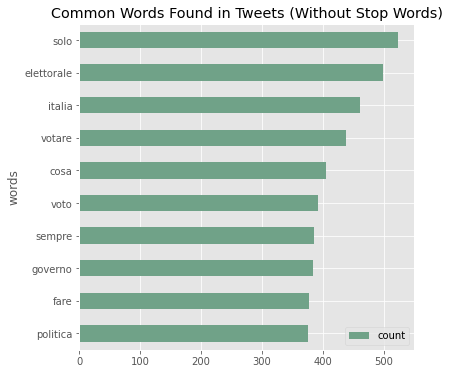

In [70]:
import pandas as pd

all_words = ' '.join([word for word in df['Clean_Tweets']])

# obtain most common words

words = nltk.word_tokenize(all_words)
fd = FreqDist(words)
# obtain top 15
top_15 = fd.most_common(15)

top_15_df = pd.DataFrame(top_15,
                         columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(6, 6))

#Plot horizontal bar graph

top_15_df.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="#70A288")

ax.set_title("Common Words Found in Tweets (Without Stop Words)")

plt.show()


Text(0.5, 0.98, 'Common HashTags')

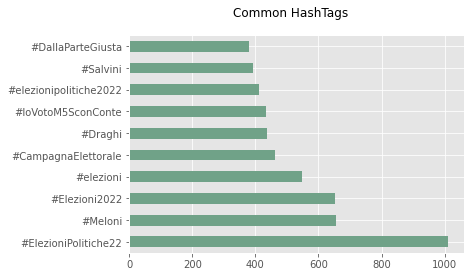

In [71]:
#This function extracts hashtags from the tweets.

import pandas as pd

def find_hashtags(tweet):
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)
  
df['Hashtags'] = df['Tweets'].apply(find_hashtags)

#Handling tweet with more then one hashtag
hashtag_list = df['Hashtags'].to_list()
flat_hashtags_df = pd.DataFrame([item for sublist in hashtag_list for item in sublist])
flat_hashtags_df.shape

#change the name of the column to hashtags
flat_hashtags_df.columns = ['Hashtags']

#most used hashtags
flat_hashtags_df['Hashtags'].value_counts()[1:11].plot(kind='barh', color = '#70A288')  #from 1 to 11 because the first most used is the original hashtag used for collect the tweets
plt.suptitle('Common HashTags')

Text(0.5, 0.98, 'Common Mentions')

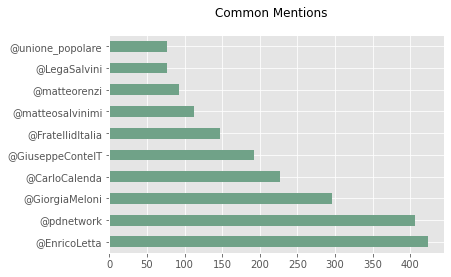

In [72]:
#Mentions
def find_mention(tweet):
    return re.findall('(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)
  
df['Mentions'] = df['Tweets'].apply(find_mention)

#Handling tweet with more then one Mention
mention_list = df['Mentions'].to_list()
flat_mention_df = pd.DataFrame([item for sublist in mention_list for item in sublist])
flat_mention_df.shape

#change the name of the column to Mentions
flat_mention_df.columns = ['Mentions']
flat_mention_df.head()

#most used hashtags
flat_mention_df['Mentions'].value_counts()[:10].plot(kind='barh', color='#70A288')
plt.suptitle('Common Mentions')

## Sentiment Analysis

In [73]:
#Library for Sentiment Analysis in italian
!pip install -U feel-it
from feel_it import SentimentClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [74]:
sentiment_classifier = SentimentClassifier()

sentiment = (sentiment_classifier.predict(df["Clean_Tweets"].values.tolist())) 

print(sentiment)
print(len(sentiment))

['positive', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'positive', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'positive', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'ne

In [75]:
df['Sentiment'] = sentiment
df.head(5)



,Tweets,Date,PD,FDI,Clean_Tweets,Tweets_token,Hashtags,Mentions,Sentiment
0,Conferenza stampa di presentazione delle liste...,2022-08-31,0,0,conferenza stampa presentazione liste popolare...,"[conferenza, stampa, presentazione, liste, pop...","[#UnionePopolare, #ElezioniPolitiche2022, #Cat...","[@unione_popolare, @Sandro_Russo74]",positive
1,La serietà con la quale il leader del #TerzoPo...,2022-08-31,0,0,serietà leader accusa giornalista avergli fatt...,"[serietà, leader, accusa, giornalista, avergli...","[#TerzoPolo, #madraghilosa, #sulserio, #Elezio...",[],negative
2,#calenda e #renzi già alleati con l' estrema #...,2022-08-31,0,0,già alleati estrema pro fan lassassino dichiar...,"[già, alleati, estrema, pro, fan, lassassino, ...","[#calenda, #renzi, #sinistra, #comunismo, #urs...",[],negative
3,Che è come dire “Basta con il bipopulismo port...,2022-08-31,0,0,dire basta bipopulismo porti aperti porti chiu...,"[dire, basta, bipopulismo, porti, aperti, port...","[#TerzoPolo, #ElezioniPolitiche2022]",[],negative
4,È bello vedere con i propri occhi tantissimi r...,2022-08-31,0,0,bello vedere propri occhi tantissimi ragazzi l...,"[bello, vedere, propri, occhi, tantissimi, rag...","[#ElezioniPolitiche2022, #credo]",[@matteosalvinimi],positive


## Emontion analysis

In [76]:
#Emotion Analysis

from feel_it import EmotionClassifier

emotion_classifier = EmotionClassifier()

emotion = (emotion_classifier.predict(df["Clean_Tweets"].values.tolist()))

df['Emotions'] = emotion

df.head(5)



,Tweets,Date,PD,FDI,Clean_Tweets,Tweets_token,Hashtags,Mentions,Sentiment,Emotions
0,Conferenza stampa di presentazione delle liste...,2022-08-31,0,0,conferenza stampa presentazione liste popolare...,"[conferenza, stampa, presentazione, liste, pop...","[#UnionePopolare, #ElezioniPolitiche2022, #Cat...","[@unione_popolare, @Sandro_Russo74]",positive,fear
1,La serietà con la quale il leader del #TerzoPo...,2022-08-31,0,0,serietà leader accusa giornalista avergli fatt...,"[serietà, leader, accusa, giornalista, avergli...","[#TerzoPolo, #madraghilosa, #sulserio, #Elezio...",[],negative,anger
2,#calenda e #renzi già alleati con l' estrema #...,2022-08-31,0,0,già alleati estrema pro fan lassassino dichiar...,"[già, alleati, estrema, pro, fan, lassassino, ...","[#calenda, #renzi, #sinistra, #comunismo, #urs...",[],negative,anger
3,Che è come dire “Basta con il bipopulismo port...,2022-08-31,0,0,dire basta bipopulismo porti aperti porti chiu...,"[dire, basta, bipopulismo, porti, aperti, port...","[#TerzoPolo, #ElezioniPolitiche2022]",[],negative,anger
4,È bello vedere con i propri occhi tantissimi r...,2022-08-31,0,0,bello vedere propri occhi tantissimi ragazzi l...,"[bello, vedere, propri, occhi, tantissimi, rag...","[#ElezioniPolitiche2022, #credo]",[@matteosalvinimi],positive,joy


## Focus on left-wing party (PD)

In [77]:
#Filtering on pd
df_pd = df[df['PD'] == 1]


df_pd


,Tweets,Date,PD,FDI,Clean_Tweets,Tweets_token,Hashtags,Mentions,Sentiment,Emotions
5,@TgLa7 @luigidimaio Alla fine ti sei candidato...,2022-08-31,1,0,fine candidato definivi partito bibbiano spieg...,"[fine, candidato, definivi, partito, bibbiano,...","[#PD, #ElezioniPolitiche2022, #corsaalvoto]","[@TgLa7, @luigidimaio]",negative,anger
8,Vabbè fate finta ma non volete vincere #Elezio...,2022-08-31,1,0,vabbè fate finta volete vincere,"[vabbè, fate, finta, volete, vincere]","[#ElezioniPolitiche2022, #dallapartegiusta, #p...","[@pdnetwork, @EnricoLetta]",negative,anger
23,#letta a @RaiPortaaPorta parla di #votoutile f...,2022-08-31,1,0,parla dichiarazione resa perso,"[parla, dichiarazione, resa, perso]","[#letta, #votoutile, #ElezioniPolitiche2022]",[@RaiPortaaPorta],negative,sadness
30,#ElezioniPolitiche2022 Mi raccomando amici #Io...,2022-08-31,1,1,raccomando amici uniamo forze sostenere mai bi...,"[raccomando, amici, uniamo, forze, sostenere, ...","[#ElezioniPolitiche2022, #IoVotoM5SconConte, #...",[],negative,anger
31,In #trentino il #PD è alleato con #calenda.\n#...,2022-08-31,1,0,alleato,[alleato],"[#trentino, #PD, #calenda, #ElezioniPolitiche2...",[],negative,fear
...,...,...,...,...,...,...,...,...,...,...
10890,@EnricoLetta @MeetingRimini @Corriere Siete la...,2022-08-23,1,0,disgrazia italiana 30 anni sx amp dx fate ribr...,"[disgrazia, italiana, 30, anni, sx, amp, dx, f...","[#IoVotoM5SconConte, #DallaParteGiusta, #Elezi...","[@EnricoLetta, @MeetingRimini, @Corriere]",negative,anger
10892,"La molletta per il 25, il tappo per il 26.\n#E...",2022-08-23,1,0,molletta 25 tappo 26,"[molletta, 25, tappo, 26]","[#ElezioniPolitiche2022, #Elezioni2022, #elezi...",[],negative,fear
10898,L'irriducibile scontro @EnricoLetta @GiorgiaMe...,2022-08-23,1,1,lirriducibile scontro,"[lirriducibile, scontro]","[#meetingRimini, #Rimini, #EnricoLetta, #giorg...","[@EnricoLetta, @GiorgiaMeloni]",negative,anger
10910,"Che buffonate sta combinando sto PD, su Calend...",2022-08-23,1,0,buffonate combinando pd calenda nemmeno esprimo,"[buffonate, combinando, pd, calenda, nemmeno, ...",[#ElezioniPolitiche2022],[],negative,anger


###Sentiment Analysis

In [78]:
#Percentage positive tweets for PD

df_pd_positive = df_pd[df_pd['Sentiment'] == 'positive']

df_pd_positive_words = df_pd_positive['Tweets_token']

percentage_positive = round((df_pd_positive_words.shape[0] / df_pd.shape[0]*100), 1)

print('The percentage of positive tweets for PD is', percentage_positive, '%')

#Percentage negative tweets for PD

df_pd_negative = df_pd[df_pd['Sentiment'] == 'negative']

df_pd_negative_words = df_pd_negative['Tweets_token']

percentage_negative = round((df_pd_negative_words.shape[0] / df_pd.shape[0]*100), 1)

print('The percentage of neagtive tweets for PD is', percentage_negative, '%')

The percentage of positive tweets for PD is 10.4 %
The percentage of neagtive tweets for PD is 89.6 %


[Text(0.5, 1.0, 'Sentiment Analysis PD')]

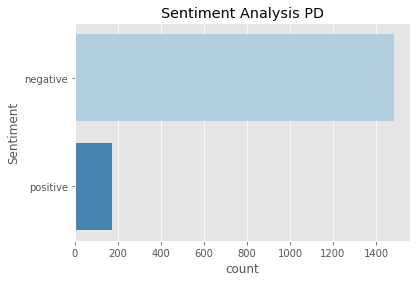

In [79]:
#Counts visulization

sns.countplot(y='Sentiment', 
             data=df_pd, 
             palette=sns.color_palette('Blues', n_colors=2)
             ).set(title='Sentiment Analysis PD')

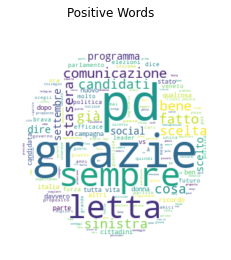

In [80]:
#Wordloud  Positive words fro PD

df_pd_positive = df_pd[df_pd['Sentiment'] == 'positive']

positive_words = ' '.join([word for word in df_pd_positive['Clean_Tweets']])

# makes the circle using numpy
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

positive_wordcloud = WordCloud(background_color="white", repeat=True, mask=mask)
positive_wordcloud.generate(positive_words)

#Display the generated image
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.suptitle('Positive Words')
plt.show()


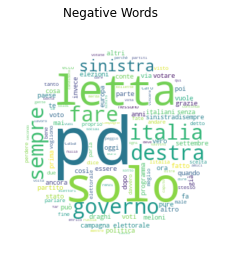

In [81]:
#Wordcloud Negative words for PD 

df_pd_negative = df_pd[df_pd['Sentiment'] == 'negative']

negative_words = ' '.join([word for word in df_pd_negative['Clean_Tweets']])

# makes the circle using numpy
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

negative_wordcloud = WordCloud(background_color="white", repeat=True, mask=mask)
negative_wordcloud.generate(negative_words)

#Display the generated image
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.suptitle('Negative Words')
plt.show()

In [82]:
#Timeseries graph 

##Preprocess
df_negative_words = df_pd_negative.groupby(['Date'],as_index=False).count()
df_negative_words

df_positive_words = df_pd_positive.groupby(['Date'],as_index=False).count()
df_positive_words

pos = df_positive_words[['Date','Clean_Tweets']]
neg = df_negative_words[['Date','Clean_Tweets']]

##Plot
import plotly.graph_objs as go

fig = go.Figure()
for col in pos.columns:
    fig.add_trace(go.Scatter(x=pos['Date'], y=pos['Clean_Tweets'],
                             name = 'Positive',
                             mode = 'markers+lines',
                             line=dict(shape='linear'),
                             connectgaps=True,
                             line_color='#0C56BC',
                             
                             )
                 )

for col in neg.columns:
    fig.add_trace(go.Scatter(x=neg['Date'], y=neg['Clean_Tweets'],
                             name = 'Negative',
                             mode = 'markers+lines',
                             line=dict(shape='linear'),
                             connectgaps=True,
                             line_color='#cb181d'
                             )
                 )
    
fig.update_layout(
    title="Time-series graph for PD",
    xaxis_title="Date",
    yaxis_title="Count",
    #showlegend=False,
    autosize=False,
    width=1000,
    height=400)

fig.show()

###Emotion Analysis

In [83]:
#Percentage tweets based on Anger for PD

df_pd_anger = df_pd[df_pd['Emotions'] == 'anger']

df_pd_anger_words = df_pd_anger['Tweets_token']

percentage_anger_pd = round((df_pd_anger_words.shape[0] / df_pd.shape[0]*100), 1)

print('The percentage of tweets based on anger for PD is', percentage_anger_pd, '%')


#Percentage tweets based on Fear for PD

df_pd_fear = df_pd[df_pd['Emotions'] == 'fear']

df_pd_fear_words = df_pd_fear['Tweets_token']

percentage_fear_pd = round((df_pd_fear_words.shape[0] / df_pd.shape[0]*100), 1)

print('The percentage of tweets based on fear for PD is', percentage_fear_pd, '%')


#Percentage tweets based on Joy for PD

df_pd_joy = df_pd[df_pd['Emotions'] == 'joy']

df_pd_joy_words = df_pd_joy['Tweets_token']

percentage_joy_pd = round((df_pd_joy_words.shape[0] / df_pd.shape[0]*100), 1)

print('The percentage of tweets based on joy for PD is', percentage_joy_pd, '%')


#Percentage tweets based on Sadness for PD

df_pd_sadness = df_pd[df_pd['Emotions'] == 'sadness']

df_pd_sadness_words = df_pd_sadness['Tweets_token']

percentage_sadness_pd = round((df_pd_sadness_words.shape[0] / df_pd.shape[0]*100), 1)

print('The percentage of tweets based on sadness for PD is', percentage_sadness_pd, '%')

The percentage of tweets based on anger for PD is 76.6 %
The percentage of tweets based on fear for PD is 7.9 %
The percentage of tweets based on joy for PD is 11.2 %
The percentage of tweets based on sadness for PD is 4.4 %


[Text(0.5, 1.0, 'Emotion Analysis PD')]

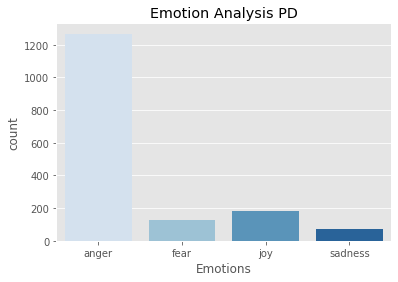

In [84]:
#Emotions counts vis
Emotion_ordered = df_pd.sort_values('Emotions')

sns.countplot(x='Emotions', 
             data=Emotion_ordered, 
             palette=sns.color_palette('Blues', n_colors=4)
             ).set(title='Emotion Analysis PD')


## Focus on right-wing party (FDI)

In [85]:
#Filtering on FDI

df_fdi = df[df['FDI'] == 1]

df_fdi

,Tweets,Date,PD,FDI,Clean_Tweets,Tweets_token,Hashtags,Mentions,Sentiment,Emotions
9,@GiorgiaMeloni Cominci a essere chiara lei. No...,2022-08-31,0,1,cominci essere chiara opposta nulla scorso ann...,"[cominci, essere, chiara, opposta, nulla, scor...",[#ElezioniPolitiche2022],[@GiorgiaMeloni],negative,anger
15,@DSantanche @GiorgiaMeloni IL PROBLEMA NON E' ...,2022-08-31,0,1,problema gente voie affini voto,"[problema, gente, voie, affini, voto]","[#redditodicittadinanza, #M5S, #DallaParteGius...","[@DSantanche, @GiorgiaMeloni]",negative,anger
27,Questa uscita fa capire il vero problema della...,2022-08-31,0,1,uscita fa capire vero problema destra diverso ...,"[uscita, fa, capire, vero, problema, destra, d...","[#Diversity, #Meloni, #ElezioniPolitiche2022]",[],negative,anger
28,Grandissime ragazze!!.\n#Melonivergogna\n#Elez...,2022-08-31,0,1,grandissime ragazze,"[grandissime, ragazze]","[#Melonivergogna, #ElezioniPolitiche2022]",[],positive,joy
29,#ElezioniPolitiche2022 \nVedo gente contro le ...,2022-08-31,0,1,vedo gente sanzioni critica carità fate bene v...,"[vedo, gente, sanzioni, critica, carità, fate,...","[#ElezioniPolitiche2022, #Putin]",[@GiorgiaMeloni],negative,anger
...,...,...,...,...,...,...,...,...,...,...
10894,Tutti i partiti hanno sottovalutato che Giorgi...,2022-08-23,0,1,partiti sottovalutato giorgia meloni candidata...,"[partiti, sottovalutato, giorgia, meloni, cand...","[#ElezioniPolitiche2022, #inonda, #donne, #Pol...",[],positive,joy
10898,L'irriducibile scontro @EnricoLetta @GiorgiaMe...,2022-08-23,1,1,lirriducibile scontro,"[lirriducibile, scontro]","[#meetingRimini, #Rimini, #EnricoLetta, #giorg...","[@EnricoLetta, @GiorgiaMeloni]",negative,anger
10907,"se vi piacciono così tanto Meloni e Salvini, i...",2022-08-23,0,1,piacciono così tanto meloni salvini 25 settemb...,"[piacciono, così, tanto, meloni, salvini, 25, ...","[#Melonivergogna, #Rimini, #ElezioniPolitiche2...",[],negative,anger
10911,Vogliono pagare col pos e gli sfascia i bagagl...,2022-08-23,0,1,vogliono pagare pos sfascia bagagli schifoso p...,"[vogliono, pagare, pos, sfascia, bagagli, schi...","[#credo, #elezioni, #lega, #giorgiameloni, #ta...",[],negative,anger


###Sentiment analysis

In [86]:
#Percentage positive tweets for FDI

df_fdi_positive = df_fdi[df_fdi['Sentiment'] == 'positive']

df_fdi_positive_words = df_fdi_positive['Tweets_token']

percentage_positive = round((df_fdi_positive_words.shape[0] / df_fdi.shape[0]*100), 1)

print('The percentage of positive tweets for PD is', percentage_positive, '%')

#Percentage negative tweets for FDI

df_fdi_negative = df_fdi[df_fdi['Sentiment'] == 'negative']

df_fdi_negative_words = df_fdi_negative['Tweets_token']

percentage_negative = round((df_fdi_negative_words.shape[0] / df_fdi.shape[0]*100), 1)

print('The percentage of neagtive tweets for PD is', percentage_negative, '%')

The percentage of positive tweets for PD is 12.2 %
The percentage of neagtive tweets for PD is 87.8 %


[Text(0.5, 1.0, 'Sentiment Analysis FdI')]

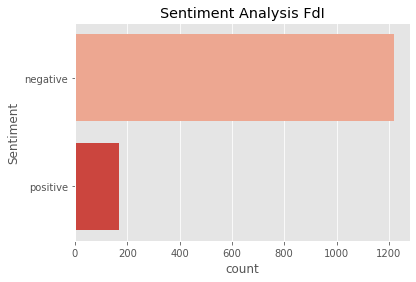

In [87]:
#Counts visulization fro fdi

sns.countplot(y='Sentiment', 
             data=df_fdi, 
             palette=sns.color_palette('Reds', n_colors=2)
             ).set(title='Sentiment Analysis FdI')

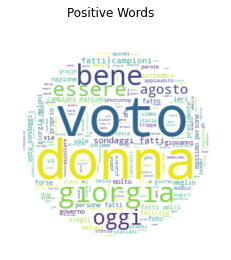

In [88]:
#Wordloud  Positive words fro FDI

df_fdi_positive = df_fdi[df_fdi['Sentiment'] == 'positive']

positive_words = ' '.join([word for word in df_fdi_positive['Clean_Tweets']])

# makes the circle using numpy
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

positive_wordcloud = WordCloud(background_color="white", repeat=True, mask=mask)
positive_wordcloud.generate(positive_words)

#Display the generated image
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.suptitle('Positive Words')
plt.show()


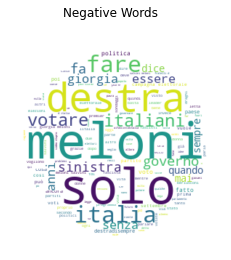

In [89]:
#Wordcloud Negative words for FDI 

df_fdi_negative = df_fdi[df_fdi['Sentiment'] == 'negative']

negative_words = ' '.join([word for word in df_fdi_negative['Clean_Tweets']])

# makes the circle using numpy
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

negative_wordcloud = WordCloud(background_color="white", repeat=True, mask=mask)
negative_wordcloud.generate(negative_words)

#Display the generated image
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.suptitle('Negative Words')
plt.show()

In [90]:
#Timeseries graph 

##Preprocess
df_negative_words = df_fdi_negative.groupby(['Date'],as_index=False).count()

df_positive_words = df_fdi_positive.groupby(['Date'],as_index=False).count()

pos = df_positive_words[['Date','Clean_Tweets']]
neg = df_negative_words[['Date','Clean_Tweets']]

##Plot
import plotly.graph_objs as go

fig = go.Figure()
for col in pos.columns:
    fig.add_trace(go.Scatter(x=pos['Date'], y=pos['Clean_Tweets'],
                             name = 'Positive',
                             mode = 'markers+lines',
                             line=dict(shape='linear'),
                             connectgaps=True,
                             line_color='#0C56BC',
                             )
                 )

for col in neg.columns:
    fig.add_trace(go.Scatter(x=neg['Date'], y=neg['Clean_Tweets'],
                             name = 'Negative',
                             mode = 'markers+lines',
                             line=dict(shape='linear'),
                             connectgaps=True,
                             line_color='#cb181d'
                             )
                 )
    
fig.update_layout(
    title="Time-series graph for FdI",
    xaxis_title="Date",
    yaxis_title="Count",
    #showlegend=False,
    autosize=False,
    width=1000,
    height=400)

fig.show()


### Emotion Analysis

In [91]:
#Percentage tweets based on Anger for FDI

df_fdi_anger = df_fdi[df_fdi['Emotions'] == 'anger']

df_fdi_anger_words = df_fdi_anger['Tweets_token']

percentage_anger_fdi = round((df_fdi_anger_words.shape[0] / df_fdi.shape[0]*100), 1)

print('The percentage of tweets based on anger for FDI is', percentage_anger_fdi, '%')


#Percentage tweets based on Fear for FDI

df_fdi_fear = df_fdi[df_fdi['Emotions'] == 'fear']

df_fdi_fear_words = df_fdi_fear['Tweets_token']

percentage_fear_fdi = round((df_fdi_fear_words.shape[0] / df_fdi.shape[0]*100), 1)

print('The percentage of tweets based on fear for FDI is', percentage_fear_fdi, '%')


#Percentage tweets based on Joy for FDI

df_fdi_joy = df_fdi[df_fdi['Emotions'] == 'joy']

df_fdi_joy_words = df_fdi_joy['Tweets_token']

percentage_joy_fdi = round((df_fdi_joy_words.shape[0] / df_fdi.shape[0]*100), 1)

print('The percentage of tweets based on joy for FDI is', percentage_joy_fdi, '%')


#Percentage tweets based on Sadness for FDI

df_fdi_sadness = df_fdi[df_fdi['Emotions'] == 'sadness']

df_fdi_sadness_words = df_fdi_sadness['Tweets_token']

percentage_sadness_fdi = round((df_fdi_sadness_words.shape[0] / df_fdi.shape[0]*100), 1)

print('The percentage of tweets based on sadness for FDI is', percentage_sadness_fdi, '%')

The percentage of tweets based on anger for FDI is 72.8 %
The percentage of tweets based on fear for FDI is 9.1 %
The percentage of tweets based on joy for FDI is 12.9 %
The percentage of tweets based on sadness for FDI is 5.2 %


[Text(0.5, 1.0, 'Emotion Analysis FdI')]

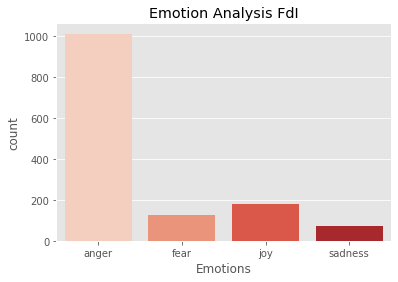

In [92]:
#Emotions counts vis
Emotion_ordered = df_fdi.sort_values('Emotions')


sns.countplot(x='Emotions', 
             data=Emotion_ordered, 
             palette=sns.color_palette('Reds', n_colors=4)
             ).set(title='Emotion Analysis FdI')